# Anime Datasets working

## Utils used in database student

In [ ]:
import requests as req
import pandas as pd

def get_anime_data(query, variable = None):
  """
  Get anime data from anilist API

  :params
      query: str
      variable: dict

  :return dict
  """
  try:
    response = req.post(
      url = "https://graphql.anilist.co",
      json = {
        "query" : query,
        "variables" : variable
      }
    )
    return response.json()
  except req.ConnectionError as e:
    print(f"[ERROR] : Conection to graphql fail {e}")


def count_values_in_column(df):
  """
  Count total values in a column and past a pandas series

  :params
      df: pandas.Series

  :return pandas.Series
  """
  separate_data = []

  for items in df:
    if isinstance(items, str):
      separate_data.extend([item.strip() for item in items.split(",")])
    elif isinstance(items, list):
      separate_data.extend(items)
      value_counts = pd.Series(separate_data).value_counts()

  return value_counts


## Get data information in anime API and save in a variable

In [ ]:
import time

query = '''
query ($page: Int, $perPage: Int, $startDate: FuzzyDateInt, $endDate: FuzzyDateInt) {
  Page(page: $page, perPage: $perPage) {
    media(type: ANIME, startDate_greater: $startDate, startDate_lesser: $endDate, format_not: MOVIE) {
      id
      title {
        english
      }
      format
      season
      seasonYear
      popularity
      averageScore
      episodes
      duration
      status
      genres
      characters(role: MAIN) {
        nodes {
          gender
        }
      }
    }
  }
}
'''

# Ajuste en las variables
variables = {
    "page": 1,
    "perPage": 150,
    "startYear": 2010,
    "endYear": 2024
}

all_animes = []
total_pages = 80
for page in range(1, total_pages):
  try:
    variables['page'] = page
    data = get_anime_data(query, variables)

    animes = data['data']['Page']['media']
    all_animes.extend(animes)

    print(f"Obtain data in page {page}...")
    time.sleep(2)
  except TypeError as e:
    print(f"[ERROR] : {e}")
    continue

##  Fit data and save data to a data file

In [ ]:
import pandas as pd
import numpy as np
import re

df_list = []
for anime in all_animes:
  if 'characters' in anime:
      characters = anime['characters']['nodes']

      genders = []

      for character in characters:
        gender = character.get('gender')
        if gender:
          genders.append(gender)

      gender_string = ', '.join(genders)


      character_data = {
          'title': anime['title']['english'],
          'format': anime['format'],
          'season': anime['season'],
          'year': anime['seasonYear'],
          'popularity': anime['popularity'],
          'score': anime['averageScore'],
          'episodes': anime['episodes'],
          'duration': anime['duration'],
          'status': anime['status'],
          'genres': ', '.join(anime['genres']),
          'character genders': gender_string
      }
      df_list.append(character_data)

df = pd.DataFrame(df_list)
print("Total register in table:", len(df))

#Cast some columns to specifics data
df['year'] = df['year'].fillna(0).astype(int)
df['popularity'] = df['popularity'].fillna(0).astype(int)
df['episodes'] = df['episodes'].fillna(0).astype(int)
df['duration'] = df['duration'].fillna(0).astype(int)

#Clear NaN or fail values and change NaN values
df.dropna(subset=['title'], inplace=True)
df['year'] = df['year'].fillna(np.nan)
df['popularity'] = df['popularity'].fillna(np.nan)
df['score'] = df['score'].fillna(np.nan)
df['episodes'] = df['episodes'].fillna(np.nan)
df['duration'] = df['duration'].fillna(np.nan)

#Clean genders and put only Male or Female
df['character genders'] = df['character genders'].apply(
    lambda genders: ', '.join(
        [re.match(r'^(Male|Female)', g.strip()).group(0) for g in genders.split(',') if re.match(r'^(Male|Female)', g.strip())]
    ) if isinstance(genders, str) else ''
)
df['character genders'] = df['character genders'].replace('', 'Other')

try:
  df.to_csv("animes.csv", index=False)
  df.to_parquet("animes.parquet", index=False)
except Exception as e:
  print(f"[ERROR] : {e}")

Total register in table: 3950


# Load data in parquet or csv archive to used

In [ ]:
import pandas as pd

path = "animes" #Location the dataset archive

anime_df = pd.read_parquet(path + ".parquet")
#anime_df = pd.read_csv(path + "csv")

print("The dataset has been loaded successfully.")
print("Total anime in load dataset: ", len(anime_df))
anime_df.head()

The dataset has been loaded successfully.
Total anime in load dataset:  2858


,title,format,season,year,popularity,score,episodes,duration,status,genres,character genders
0,Cowboy Bebop,TV,SPRING,1998,369573,86.0,26,24,FINISHED,"Action, Adventure, Drama, Sci-Fi","Male, Female, Male, Female"
1,Trigun,TV,SPRING,1998,132452,79.0,26,24,FINISHED,"Action, Adventure, Comedy, Drama, Sci-Fi","Male, Male, Female"
2,Witch Hunter ROBIN,TV,SUMMER,2002,17936,68.0,26,25,FINISHED,"Action, Drama, Mystery, Supernatural","Male, Male, Female, Female, Female, Male"
3,Beet the Vandel Buster,TV,FALL,2004,2477,63.0,52,23,FINISHED,"Adventure, Fantasy, Supernatural",Other
4,Eyeshield 21,TV,SPRING,2005,28300,76.0,145,23,FINISHED,"Action, Comedy, Sports","Male, Male, Male"


## Exploratory basic information in bar graph

<ipython-input-172-23a008e48ef1>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  graph[1, 1].set_xticklabels(series_genres.index, rotation=90)


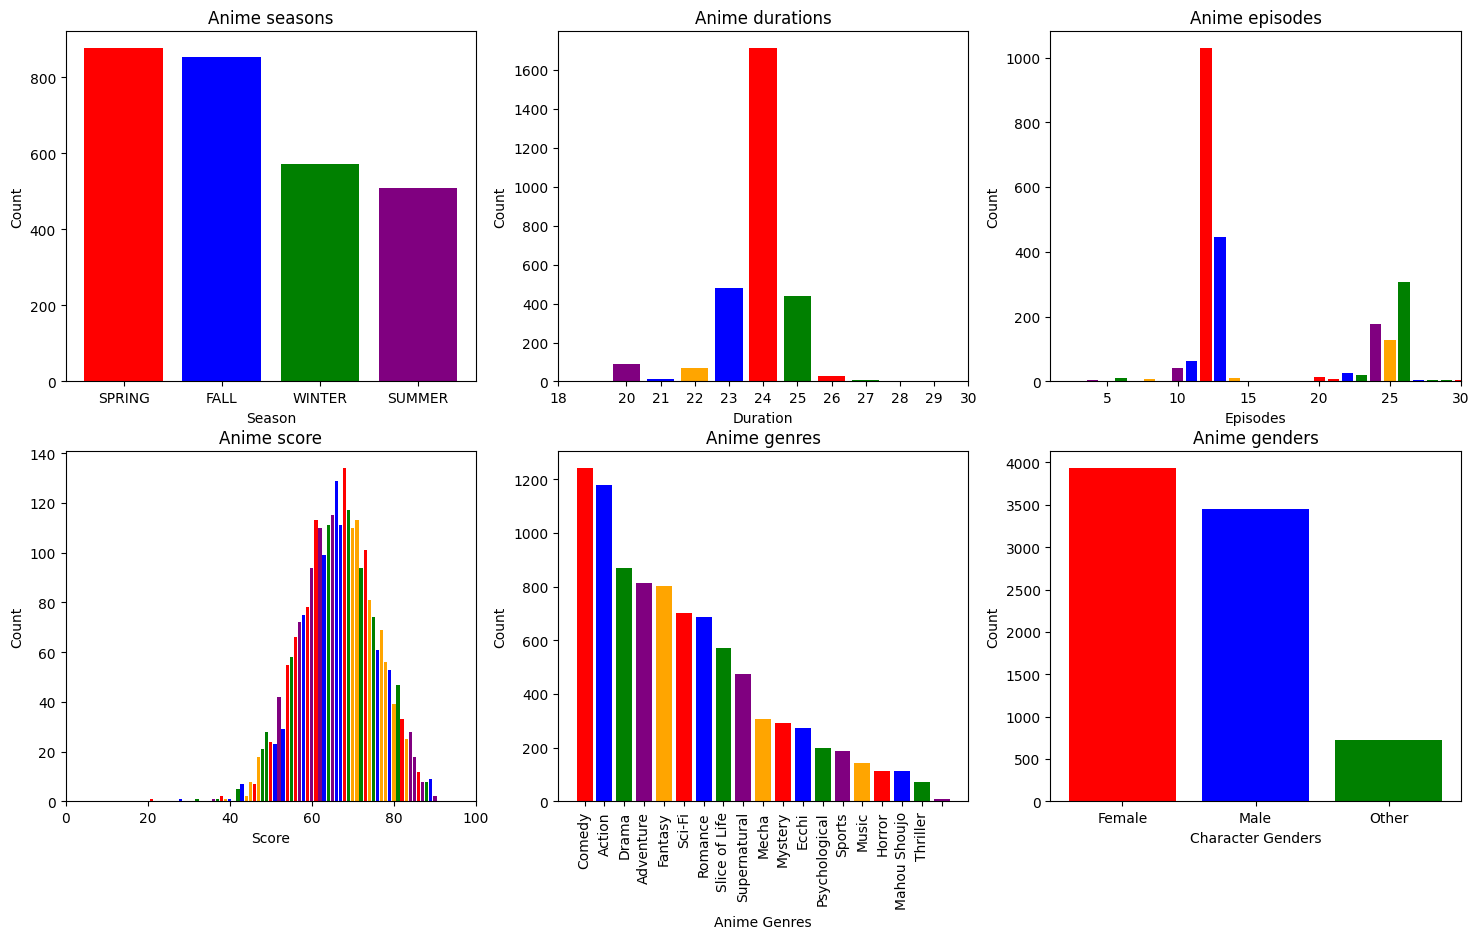

In [ ]:
from matplotlib import pyplot as plt

#Configure varius visual graph to see basic bar information
fig, graph = plt.subplots(2,3, figsize = (18,10))

colors = ('red', 'blue', 'green', 'purple', 'orange')

#Seasons bar Graph
graph[0, 0].set_title("Anime seasons")
graph[0, 0].set_xlabel("Season")
graph[0, 0].set_ylabel("Count")
graph[0, 0].bar(anime_df['season'].value_counts().index, anime_df['season'].value_counts().values, color = colors)

#Durations bar Graph
graph[0, 1].set_title("Anime durations")
graph[0, 1].set_xlabel("Duration")
graph[0, 1].set_ylabel("Count")
graph[0, 1].set_xticks(anime_df['duration'].value_counts().index)
graph[0, 1].set_xlim(18,30)
graph[0, 1].bar(anime_df['duration'].value_counts().index, anime_df['duration'].value_counts().values, color = colors)

#Episode bar Graph
graph[0, 2].set_title("Anime episodes")
graph[0, 2].set_xlabel("Episodes")
graph[0, 2].set_ylabel("Count")
graph[0, 2].set_xlim(1,30)
graph[0, 2].bar(anime_df['episodes'].value_counts().index, anime_df['episodes'].value_counts().values, color = colors)

#Score anime bar Graph
graph[1, 0].set_title("Anime score")
graph[1, 0].set_xlabel("Score")
graph[1, 0].set_ylabel("Count")
graph[1, 0].set_xlim(0,100)
score_round = anime_df['score'].fillna(0).round(0).astype(int) #Round score values and transform in int dtype
graph[1, 0].bar(score_round.value_counts().index, score_round.value_counts().values, color = colors)

#Genres animes Graph
graph[1, 1].set_title("Anime genres")
graph[1, 1].set_xlabel("Anime Genres")
graph[1, 1].set_ylabel("Count")
series_genres = count_values_in_column(anime_df['genres'])
graph[1, 1].set_xticklabels(series_genres.index, rotation=90)
graph[1, 1].bar(series_genres.index, series_genres.values, color = colors)

#Genders characters anime Graph
graph[1, 2].set_title("Anime genders")
graph[1, 2].set_xlabel("Character Genders")
graph[1, 2].set_ylabel("Count")
series_character_gender = count_values_in_column(anime_df['character genders'])
graph[1, 2].bar(series_character_gender.index, series_character_gender.values, color = colors)

plt.show()
